
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from agents.beacs import BEACS, BEACSConfiguration

# Load particular Environment Adapter
from my_examples.adapter.CartPoleEnvironmentAdapter import CartPoleEnvironmentAdapter

# Load Metrics
from my_examples.metrics.CartPoleMetrics import \
    _cartpole_metrics, \
    _check_cartpole_solved_requirement

# Load environments
import gym
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
CARTPOLE = "CartPole-v1"
CLASSIFIER_LENGTH = 4
NUMBER_OF_POSSIBLE_ACTIONS = 2
CART_POSITION = 1
CART_VELOCITY = 1
POLE_ANGLE = 6
POLE_ANGULAR_VELOCITY = 3

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 500
EPSILON = 0.5
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS = 500

#RL Set Up
GAMMA = 0.99
BETA_RL = 0.1

#BEACS Set Up
ENABLE_EP = True

#CRACS Set up
APPLY_CRACS = True

#Experiment Set up
NB_ITERATIONS = 30

## Environment - CartPole

In [3]:
def run_cartpole(nb_iteration):
    
    results = []
    
    for i in range(nb_iteration):
    
        # Initialize environment
        CartPole = gym.make(CARTPOLE)
        # Reset it, by putting an agent into random position
        state = CartPole.reset()

        buckets = (CART_POSITION, CART_VELOCITY, POLE_ANGLE, POLE_ANGULAR_VELOCITY)

        cfg_explore = BEACSConfiguration(
            classifier_length=CLASSIFIER_LENGTH,
            number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
            environment_adapter=CartPoleEnvironmentAdapter(buckets=buckets),
            user_metrics_collector_fcn=_cartpole_metrics,
            metrics_trial_frequency=1,
            do_ep=ENABLE_EP,
            beta_alp=BETA_ALP,
            beta_rl=BETA_RL,
            gamma=GAMMA,
            epsilon=EPSILON,
            u_max=CLASSIFIER_LENGTH,
            mu=0.,
            chi=0.,
            bs_max=0,
            seed=None
        )

        agent_explore = BEACS(cfg_explore)
        population_explore, metrics_explore = agent_explore.explore(CartPole, NUMBER_OF_EXPLORE_TRIALS)
        if APPLY_CRACS:
            agent_explore.apply_CRACS()
            population_explore = agent_explore.get_population()

        cfg_exploit = BEACSConfiguration(
            classifier_length=CLASSIFIER_LENGTH,
            number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
            environment_adapter=CartPoleEnvironmentAdapter(),
            user_metrics_collector_fcn=_cartpole_metrics,
            metrics_trial_frequency=1,
            do_ep=ENABLE_EP,
            beta_alp=BETA_ALP,
            beta_rl=BETA_RL,
            gamma=GAMMA,
            epsilon=0.0,
            u_max=CLASSIFIER_LENGTH,
            bs_max=0,
            seed=None
        )
        agent_exploit = BEACS(cfg_exploit, population_explore)
        population_exploit, metrics_exploit = agent_exploit.exploit(CartPole, NUMBER_OF_EXPLOIT_TRIALS)

        trials=[]
        avg_step_explore = 0
        for trial in metrics_explore:
            trials.append(trial['steps_in_trial'])
            avg_step_explore += trial['steps_in_trial']
        avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / 1
        avg_step_exploit = 0
        for trial in metrics_exploit:
            trials.append(trial['steps_in_trial'])
            avg_step_exploit += trial['steps_in_trial']
        avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
        average_scores, solved = _check_cartpole_solved_requirement(trials)

        cartpole_metrics = _cartpole_metrics(population_exploit, CartPole)

        result = {
            'number' : i+1,
            'population' : cartpole_metrics['population'],
            'numerosity' : cartpole_metrics['numerosity'],
            'reliable'   : cartpole_metrics['reliable'],
            'avg_step_explore' : avg_step_explore,
            'avg_step_exploit' : avg_step_exploit,
            'average_scores'   : average_scores,
            'solved' : solved
        }
        print("Cartpole n°{} : average {} - solved at {}".format(i+1, result['avg_step_exploit'], result['solved']))
        results.append(result)
    
    return results

In [4]:
results = run_cartpole(NB_ITERATIONS)

/usr/local/Caskroom/miniconda/base/envs/alcs/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Cartpole n°1 : average 500.0 - solved at 596
Cartpole n°2 : average 498.446 - solved at 598
Cartpole n°3 : average 498.056 - solved at 597
Cartpole n°4 : average 500.0 - solved at 596
Cartpole n°5 : average 496.552 - solved at 600
Cartpole n°6 : average 499.108 - solved at 597
Cartpole n°7 : average 500.0 - solved at 595
Cartpole n°8 : average 500.0 - solved at 595
Cartpole n°9 : average 500.0 - solved at 596
Cartpole n°10 : average 499.032 - solved at 597
Cartpole n°11 : average 500.0 - solved at 595
Cartpole n°12 : average 500.0 - solved at 596
Cartpole n°13 : average 500.0 - solved at 596
Cartpole n°14 : average 499.04 - solved at 597
Cartpole n°15 : average 500.0 - solved at 596
Cartpole n°16 : average 500.0 - solved at 596
Cartpole n°17 : average 498.132 - solved at 598
Cartpole n°18 : average 500.0 - solved at 595
Cartpole n°19 : average 494.262 - solved at 602
Cartpole n°20 : average 500.0 - solved at 596
Cartpole n°21 : average 494.602 - solved at 602
Cartpole n°22 : average 49

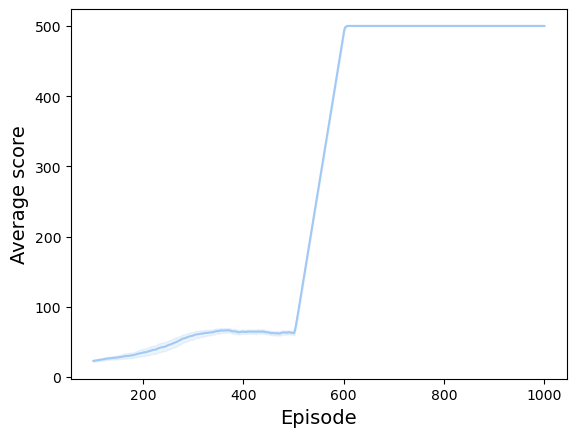

In [11]:
def prepare_pandas_plotting_data(raw_data):
    cleaned_data = {
        'Episode' : [i for i in range(101,NUMBER_OF_EXPLORE_TRIALS+NUMBER_OF_EXPLOIT_TRIALS+1)]
    }
    for i in range(len(raw_data)):
        cleaned_data["Cartpole n°"+str(i+1)] = raw_data[i]['average_scores']
    pandas_data = pd.DataFrame(cleaned_data)
    return pandas_data

pandas_data = prepare_pandas_plotting_data(results)

palette = sns.color_palette('pastel')
c=palette[0]
sns.lineplot(x='Episode', y='value', data=pd.melt(pandas_data, ['Episode']), color=c)
plt.xlabel("Episode", fontsize = 14) # label for x-axis
plt.ylabel("Average score", fontsize = 14) # label for y-axis
plt.show()

In [14]:
pandas_data.to_csv('df_cartpole_beacs_debiased.csv', index=False)

import json
jsonString = json.dumps(results)
jsonFile = open('df_cartpole_beacs_debiased.json', "w")
jsonFile.write(jsonString)
jsonFile.close()